In [63]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import sklearn.ensemble
import sklearn.metrics
import sklearn.preprocessing
!pip install umap-learn
import umap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier


In [29]:
df = pandas.read_csv('master.csv')
print(f"Each column's Data Type - \n{df.dtypes}")

Each column's Data Type - 
timestamp          float64
processId            int64
parentProcessId      int64
userId               int64
processName         object
hostName            object
eventId              int64
eventName           object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object


In [30]:
# Print and inspect the first 5 records
print(f"Printing first 5 records - \n{df.head()}")

Printing first 5 records - 
    timestamp  processId  parentProcessId  userId      processName  \
0  126.233491          1                0       0          systemd   
1  126.233165        384                1     101  systemd-resolve   
2  126.233559          1                0       0          systemd   
3  126.233681          1                0       0          systemd   
4  126.233796        384                1     101  systemd-resolve   

          hostName  eventId           eventName  argsNum  returnValue  \
0  ip-10-100-1-105     1005  security_file_open        4            0   
1  ip-10-100-1-105       41              socket        3           15   
2  ip-10-100-1-105        5               fstat        2            0   
3  ip-10-100-1-105        3               close        1            0   
4  ip-10-100-1-105        3               close        1            0   

                                                args  sus  evil  
0  [{'name': 'pathname', 'type': 'const char*'

In [31]:
def preprocess(df):

  df_eng = df.copy(deep=True)
  df_eng = df_eng.drop(['timestamp'], axis=1)
  df_eng.loc[df_eng['processId'] <= 2, 'processId'] = 0
  df_eng.loc[df_eng['processId'] > 2, 'processId'] = 1
  df_eng.loc[df_eng['parentProcessId'] <= 2, 'parentProcessId'] = 0
  df_eng.loc[df_eng['parentProcessId'] > 2, 'parentProcessId'] = 1
  df_eng.loc[df_eng['userId'] < 1000, 'userId'] = 0
  df_eng.loc[df_eng['userId'] >= 1000, 'userId'] = 1
  df_eng = df_eng.drop(['processName'], axis=1)
  df_eng = df_eng.drop(['hostName'], axis=1)
  df_eng = df_eng.drop(['eventName'], axis=1)
  df_eng.loc[df_eng['returnValue'] < 0, 'returnValue'] = -1
  df_eng.loc[df_eng['returnValue'] == 0, 'returnValue'] = 0
  df_eng.loc[df_eng['returnValue'] > 0, 'returnValue'] = 1
  df_eng = df_eng.drop(['args'], axis=1)
  df_eng = df_eng.drop(['sus'], axis=1) # drop 'sus' to challenge our preictive models

  X = df_eng.drop('evil', axis=1)
  y = df_eng['evil'].values.flatten()

  return df_eng, X, y

array([[<Axes: title={'center': 'processId'}>,
        <Axes: title={'center': 'parentProcessId'}>,
        <Axes: title={'center': 'userId'}>],
       [<Axes: title={'center': 'eventId'}>,
        <Axes: title={'center': 'argsNum'}>,
        <Axes: title={'center': 'returnValue'}>],
       [<Axes: title={'center': 'evil'}>, <Axes: >, <Axes: >]],
      dtype=object)

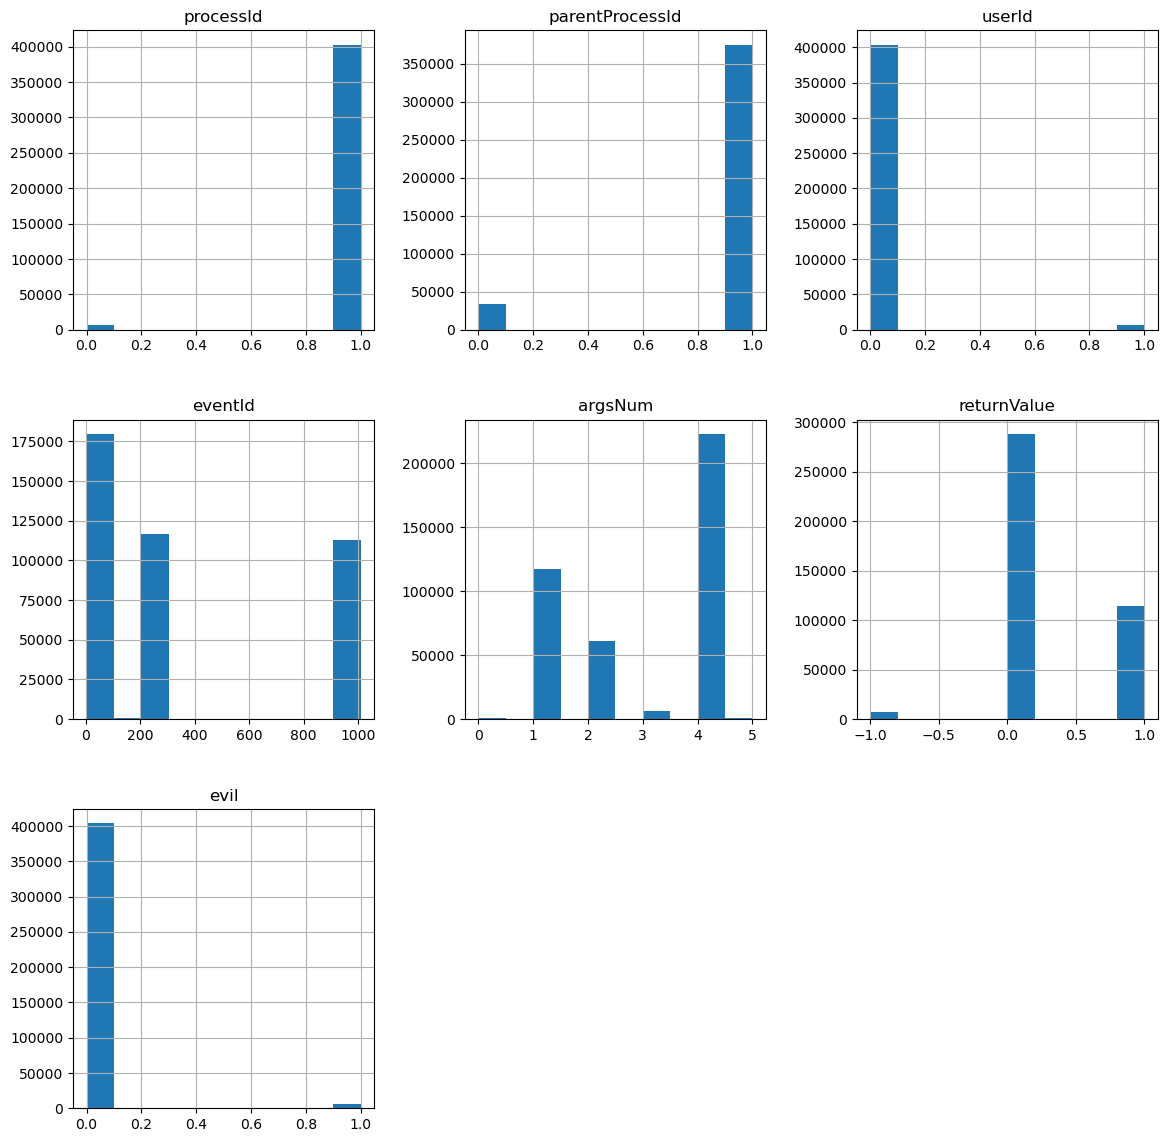

In [32]:

# Call preprocess(df) to perform feature engineering, and then
# Generate histograms of the engineered features.
df_eng, X, y = preprocess(df)
df_eng.hist(figsize=(14, 14))


<Axes: >

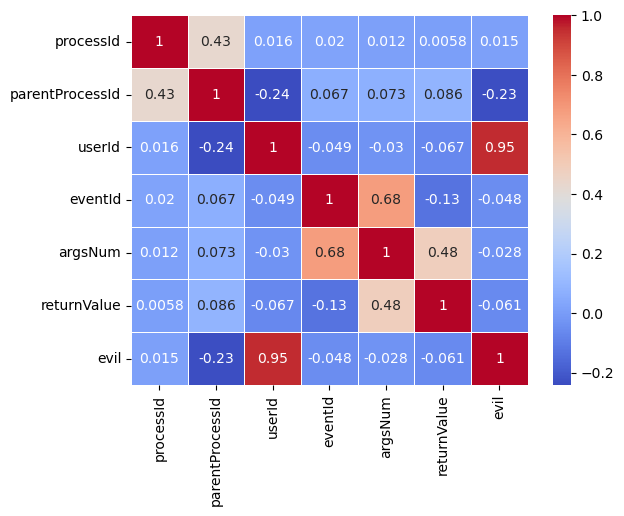

In [33]:

# plot the correlations with the seaborn heatmap() method.
seaborn.heatmap(df_eng.corr(), annot=True, cmap='coolwarm', linewidths=0.5)


In [37]:
# Encode categorical variables
encodings_dictionary = dict()
for c in df_eng.columns:
    if df_eng[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        df_eng[c] = encodings_dictionary[c].fit_transform(df_eng[c])

In [38]:
# Split the data into normal and abnormal
df_normal = df_eng[df_eng["evil"] == 0]
df_abnormal = df_eng[df_eng["evil"] == 1]

In [39]:
y_normal = df_normal.pop("evil").values
X_normal = df_normal.values
y_anomaly = df_abnormal.pop("evil").values
X_anomaly = df_abnormal.values

In [40]:
# Prepare the training and test data sets
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=0
)

X_anomaly_train, X_anomaly_test, y_anomaly_train, y_anomaly_test = train_test_split(
    X_anomaly, y_anomaly, test_size=0.2, random_state=0
)

In [41]:
X_train = numpy.concatenate((X_normal_train, X_anomaly_train))
y_train = numpy.concatenate((y_normal_train, y_anomaly_train))
X_test = numpy.concatenate((X_normal_test, X_anomaly_test))
y_test = numpy.concatenate((y_normal_test, y_anomaly_test))

In [42]:
# Scale the features
scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Train UMAP model and transform the data
umap_model = umap.UMAP()
X_train_umap = umap_model.fit_transform(X_train_scaled)

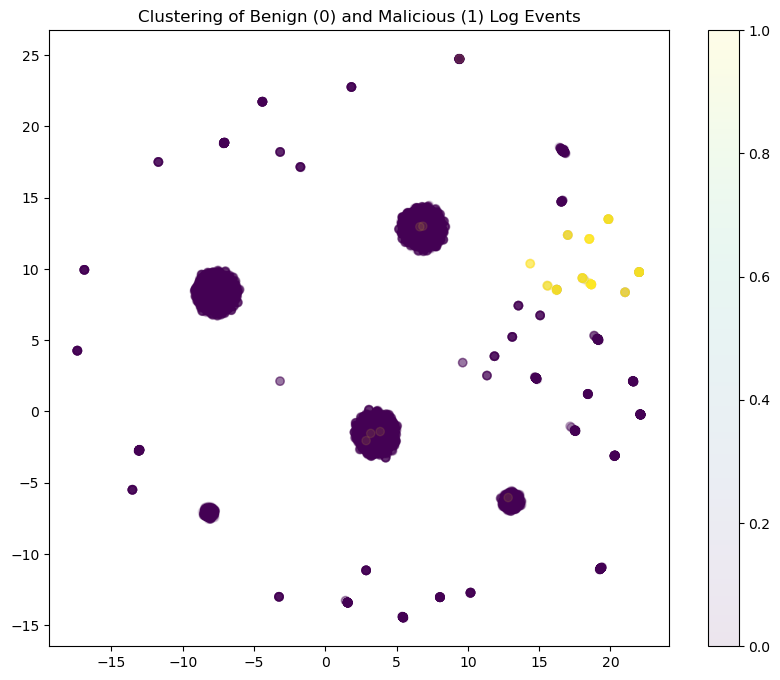

In [44]:
# Plot the UMAP-transformed data
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, alpha=0.1)
plt.title('Clustering of Benign (0) and Malicious (1) Log Events')
plt.colorbar()
plt.show()

## *Isolation Forest*

In [45]:
# Train Isolation Forest model
contamination_parameter = sum(y_train) / len(y_train)  # Proportion of anomalies in the training set
IF = sklearn.ensemble.IsolationForest(contamination=contamination_parameter, random_state=0)
IF.fit(X_train_scaled)

IsolationForest(contamination=0.01, random_state=0)

In [46]:
# Get decision scores
decision_scores_train_IF = IF.decision_function(X_train_scaled)
decision_scores_test_IF = IF.decision_function(X_test_scaled)
# Make predictions
y_pred_train_IF = IF.predict(X_train_scaled)
y_pred_test_IF = IF.predict(X_test_scaled)
# Convert predictions to binary (0 for inliers, 1 for outliers)
y_pred_train_IF = numpy.where(y_pred_train_IF == 1, 0, 1)
y_pred_test_IF = numpy.where(y_pred_test_IF == 1, 0, 1)

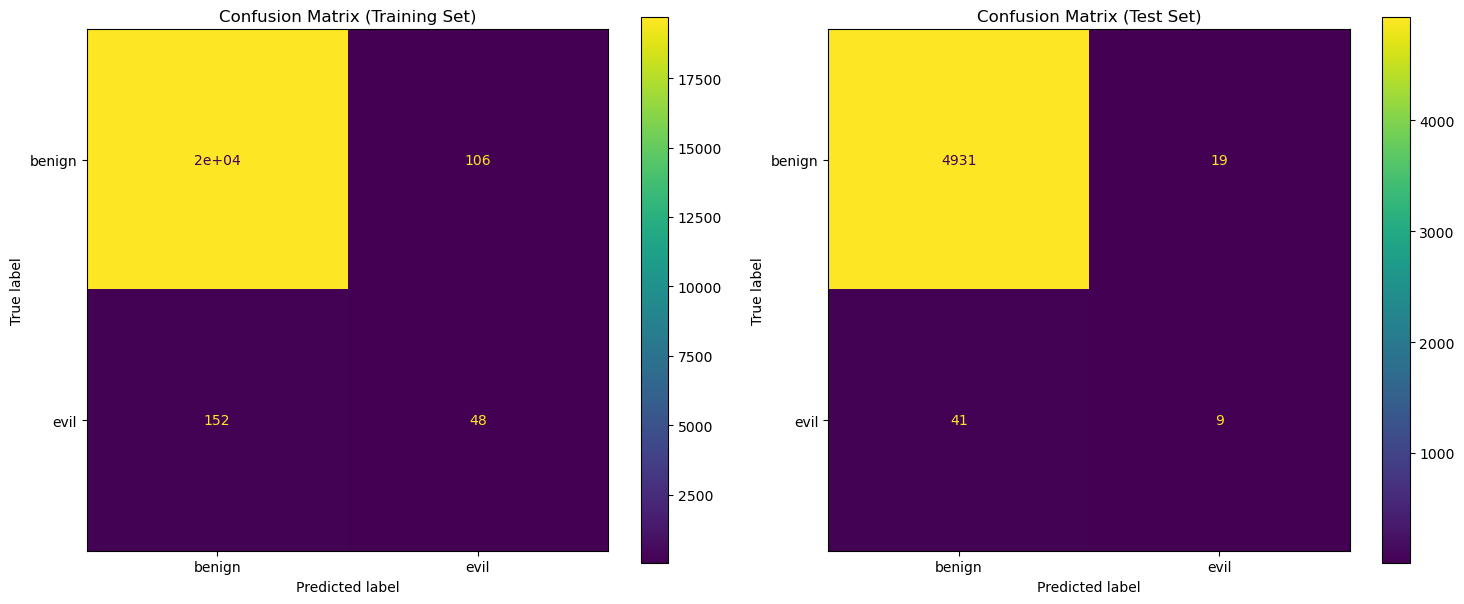

In [47]:
# Compute confusion matrix
cm_train_IF = sklearn.metrics.confusion_matrix(y_train, y_pred_train_IF)
cm_test_IF = sklearn.metrics.confusion_matrix(y_test, y_pred_test_IF)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sklearn.metrics.ConfusionMatrixDisplay(cm_train_IF, display_labels=['benign','evil']).plot(ax=ax1)
ax1.set_title('Confusion Matrix (Training Set)')

sklearn.metrics.ConfusionMatrixDisplay(cm_test_IF, display_labels=['benign','evil']).plot(ax=ax2)
ax2.set_title('Confusion Matrix (Test Set)')

plt.tight_layout()
plt.show()

In [48]:
# Print classification report
print("Classification Report (Test Set):")
print(sklearn.metrics.classification_report(y_test, y_pred_test_IF))

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4950
           1       0.32      0.18      0.23        50

    accuracy                           0.99      5000
   macro avg       0.66      0.59      0.61      5000
weighted avg       0.99      0.99      0.99      5000



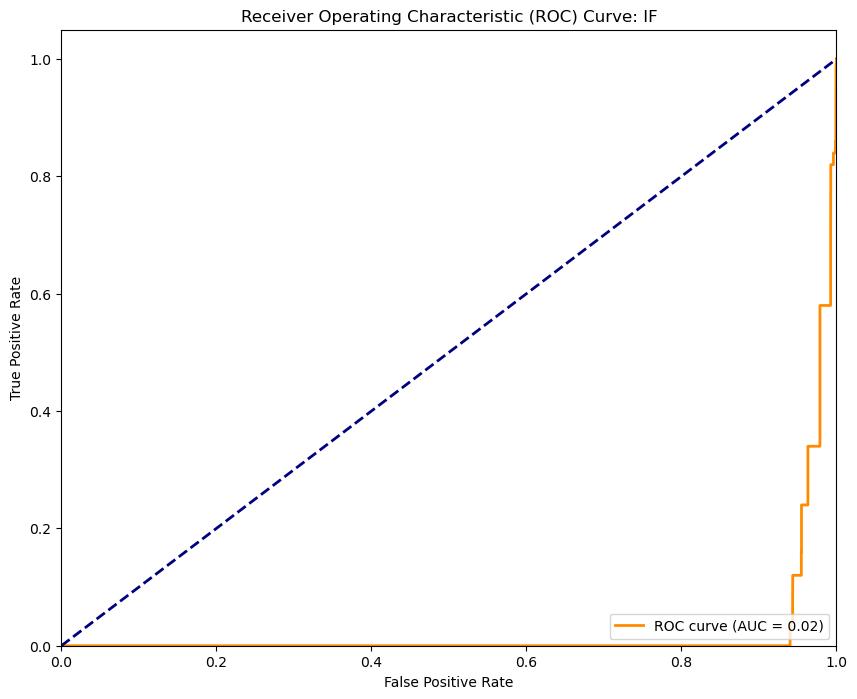

In [49]:
# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, decision_scores_test_IF)
roc_auc_IF = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_IF:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: IF')
plt.legend(loc="lower right")
plt.show()

## *Local Outlier Factor*

In [50]:
# Train Local Outlier Factor model
LOF = sklearn.neighbors.LocalOutlierFactor(n_neighbors=20, contamination=contamination_parameter, novelty=True)
LOF.fit(X_train_scaled)

LocalOutlierFactor(contamination=0.01, novelty=True)

In [51]:
# Get decision scores (negative of the outlier factor)
decision_scores_train_LOF = -LOF.score_samples(X_train_scaled)
decision_scores_test_LOF = -LOF.score_samples(X_test_scaled)

# Make predictions
y_pred_train_LOF = LOF.predict(X_train_scaled)
y_pred_test_LOF = LOF.predict(X_test_scaled)

# Convert predictions to binary (0 for inliers, 1 for outliers)
y_pred_train_LOF = numpy.where(y_pred_train_LOF == 1, 0, 1)
y_pred_test_LOF = numpy.where(y_pred_test_LOF == 1, 0, 1)

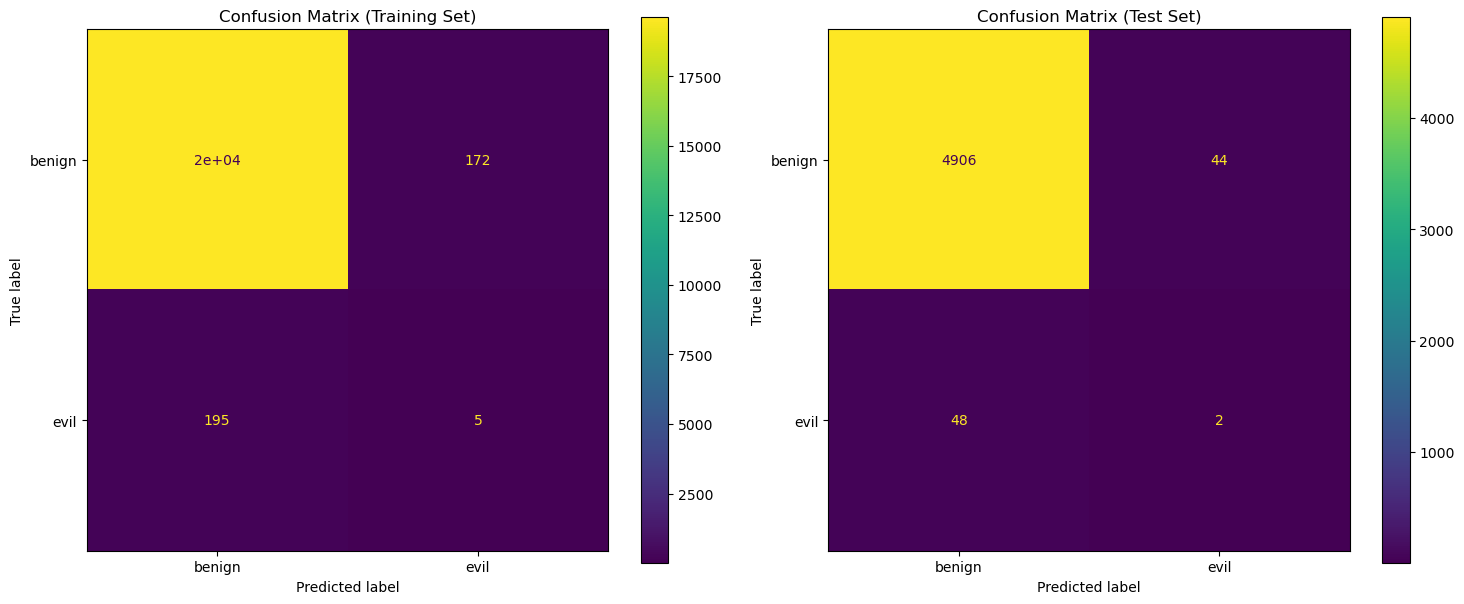

In [52]:
# Compute confusion matrix
cm_train_LOF = sklearn.metrics.confusion_matrix(y_train, y_pred_train_LOF)
cm_test_LOF = sklearn.metrics.confusion_matrix(y_test, y_pred_test_LOF)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sklearn.metrics.ConfusionMatrixDisplay(cm_train_LOF, display_labels=['benign','evil']).plot(ax=ax1)
ax1.set_title('Confusion Matrix (Training Set)')

sklearn.metrics.ConfusionMatrixDisplay(cm_test_LOF, display_labels=['benign','evil']).plot(ax=ax2)
ax2.set_title('Confusion Matrix (Test Set)')

plt.tight_layout()
plt.show()

In [53]:
# Print classification report
print("Classification Report (Test Set):")
print(sklearn.metrics.classification_report(y_test, y_pred_test_LOF))

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4950
           1       0.04      0.04      0.04        50

    accuracy                           0.98      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.98      0.98      0.98      5000



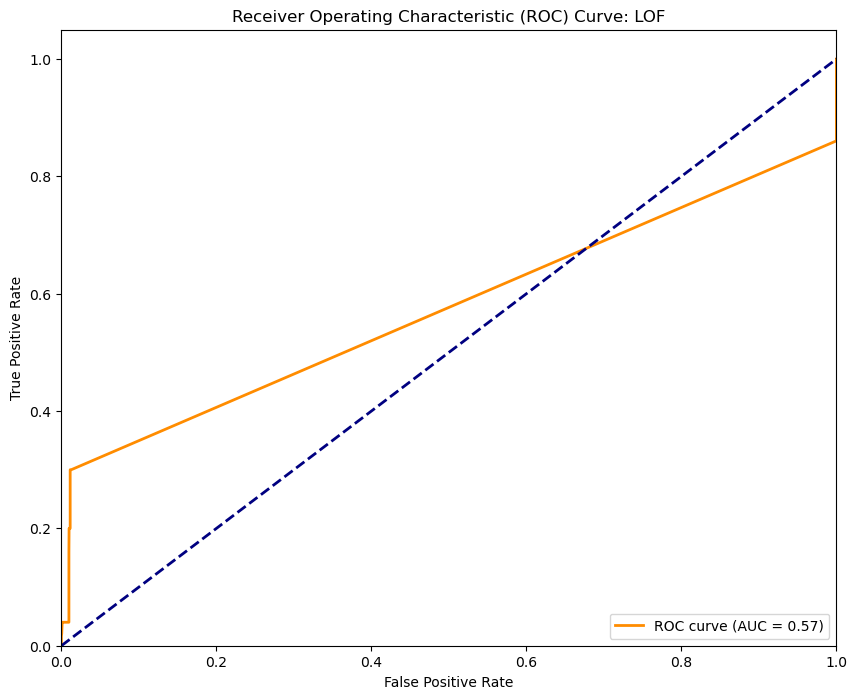

In [54]:
# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, decision_scores_test_LOF)
roc_auc_LOF = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_LOF:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: LOF')
plt.legend(loc="lower right")
plt.show()

## *One Class SVM*

In [55]:
OCSVM = OneClassSVM(kernel='rbf', nu=contamination_parameter)
OCSVM.fit(X_train_scaled)

OneClassSVM(nu=0.01)

In [56]:
# Get decision scores
decision_scores_train_OCSVM = OCSVM.decision_function(X_train_scaled)
decision_scores_test_OCSVM = OCSVM.decision_function(X_test_scaled)

# Make predictions
y_pred_train_OCSVM = OCSVM.predict(X_train_scaled)
y_pred_test_OCSVM = OCSVM.predict(X_test_scaled)

# Convert predictions to binary (0 for inliers, 1 for outliers)
y_pred_train_OCSVM = numpy.where(y_pred_train_OCSVM == 1, 0, 1)
y_pred_test_OCSVM = numpy.where(y_pred_test_OCSVM == 1, 0, 1)

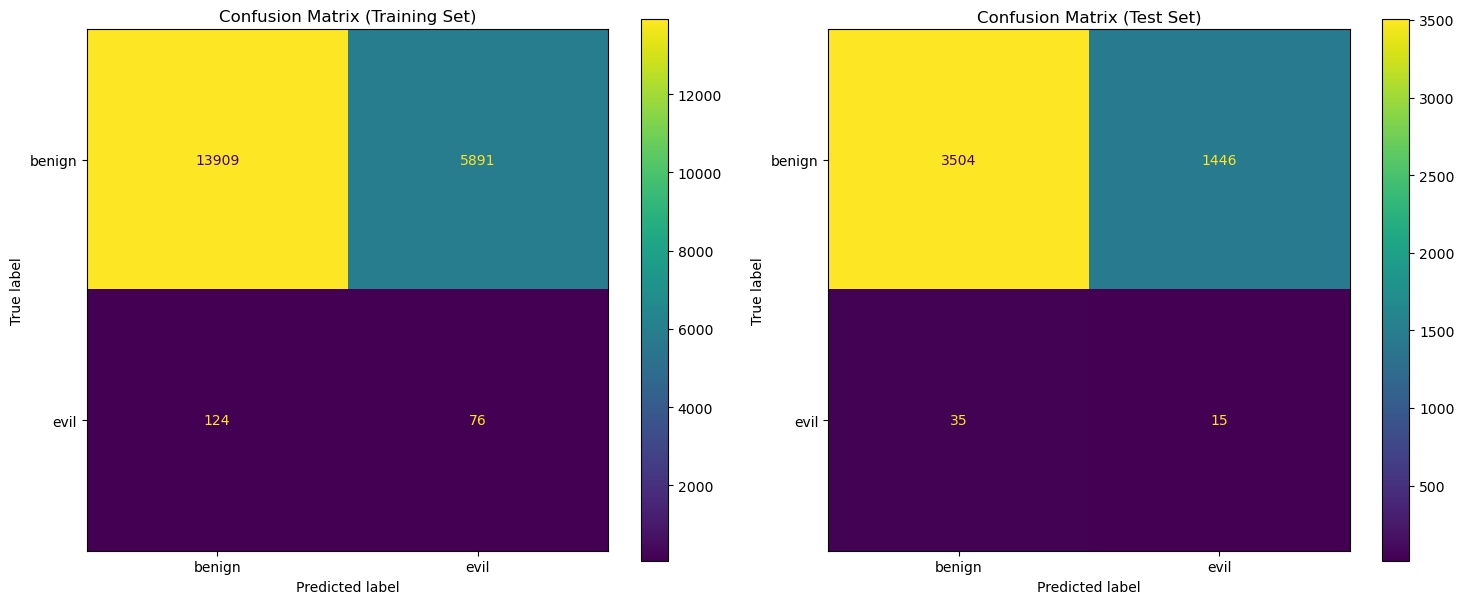

In [58]:
# Compute confusion matrix
cm_train_OCSVM = sklearn.metrics.confusion_matrix(y_train, y_pred_train_OCSVM)
cm_test_OCSVM = sklearn.metrics.confusion_matrix(y_test, y_pred_test_OCSVM)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sklearn.metrics.ConfusionMatrixDisplay(cm_train_OCSVM, display_labels=['benign','evil']).plot(ax=ax1)
ax1.set_title('Confusion Matrix (Training Set)')

sklearn.metrics.ConfusionMatrixDisplay(cm_test_OCSVM, display_labels=['benign','evil']).plot(ax=ax2)
ax2.set_title('Confusion Matrix (Test Set)')

plt.tight_layout()
plt.show()

In [59]:
# Print classification report
print("Classification Report (Test Set):")
print(sklearn.metrics.classification_report(y_test, y_pred_test_OCSVM))

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      4950
           1       0.01      0.30      0.02        50

    accuracy                           0.70      5000
   macro avg       0.50      0.50      0.42      5000
weighted avg       0.98      0.70      0.82      5000



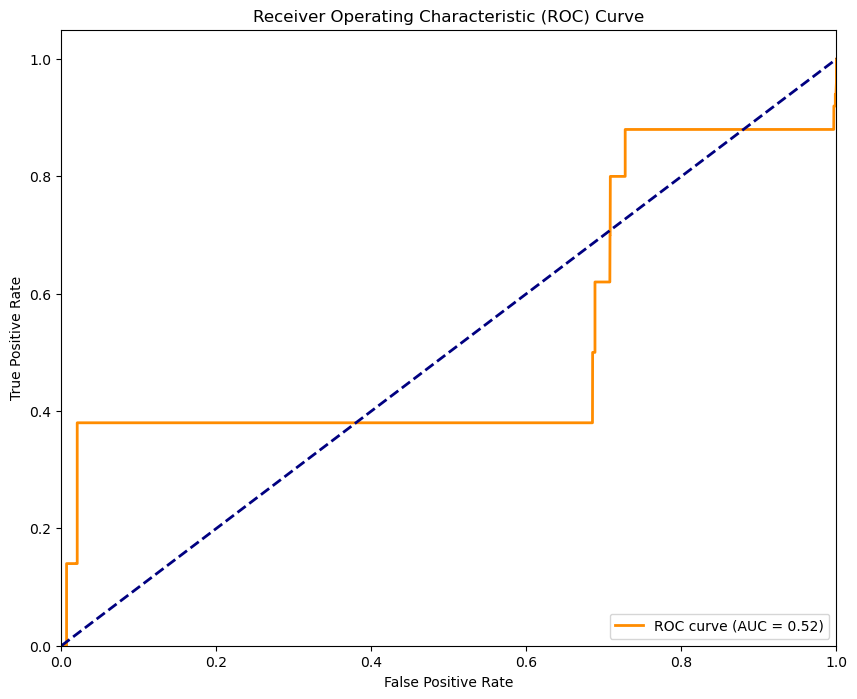

In [72]:
# Plot ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, decision_scores_test_OCSVM)
roc_auc_OCSVM = sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_OCSVM:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()